In [1]:
## This code toggles all code cells displaying on or off, so we can see output and markdown cells only.
## All code cells display can be toggled on/off.

# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# The raw code for this IPython notebook is hidden for easier reading.
# To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
## Import all the things

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import pycountry

%matplotlib inline 

# This allows cells with long text values to wrap
pd.set_option('display.max_colwidth', -1)


pd.set_option('max_rows', 200)

In [3]:
# Setting up base maps 
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # world map

# Set up function to add row/column totals to dataframes
def add_totals(df):
    df['row total'] = df.sum(axis=1)
    df = df.append(df.sum(axis=0).rename("column total"))
    return df

In [170]:
# Load csv into df
# workshops = pd.read_csv("data_files/workshops.csv")
workshops = pd.read_csv("data_files/workshops_thru_2018Q2.csv", keep_default_na=False, na_values=[''])

# Translate country codes to country names
# This does not work for Namibia (country code NA)
def get_country_name(alpha_code):
    try:
        return pycountry.countries.get(alpha_2=alpha_code).name
    except KeyError:
        return "online"

workshops['country'] = workshops['country'].apply(get_country_name)


# Clean up the tag names
workshops.loc[workshops['tag_name'].str.contains("SWC"), "workshop_type"] = "SWC"
workshops.loc[workshops['tag_name'].str.contains("DC"), "workshop_type"] = "DC"
workshops.loc[workshops['tag_name'].str.contains("LC"), "workshop_type"] = "LC"
workshops.loc[workshops['tag_name'].str.contains("TTT"), "workshop_type"] = "TTT"

workshops = workshops.drop('tag_name', axis=1)

# Clean up attendance value - this is inconsistently stored as NaN or 0
# All zero values should be NaN
workshops['attendance'] =  workshops['attendance'].replace(0.0, np.nan)

# Remove online events like maintainer onboarding 
workshops = workshops.drop(workshops[workshops.country == "online"].index)

# Date data type
workshops['start_date'] = pd.to_datetime(workshops['start_date'])

# Remove instructor training events; these will be analyzed separately.
# Limit to non TTT workshops
workshops_nonTTT = workshops[workshops['workshop_type'] != "TTT"]

# workshops_nonTTT

In [196]:
###################
# This cell creates a table with count of SWC and DC workshops by year
###################

# All workshops 2012 through 2017

workshops_by_carpentry_year_through_2017 = workshops_nonTTT[workshops_nonTTT['start_date'].dt.year<=2017]
workshops_by_carpentry_year_through_2017 = workshops_by_carpentry_year_through_2017.groupby([workshops_by_carpentry_year_through_2017['start_date'].dt.year, 'workshop_type'])['slug'].count().unstack()
# workshops_by_carpentry_year_through_2017['total'] = workshops_by_carpentry_year_through_2017.sum(axis=1)

# print("Workshops through 2017")
# display(workshops_by_carpentry_year_through_2017)

# # All workshops in 2017 full year - raw
workshops_by_carpentry_year_2017 = workshops_nonTTT[workshops_nonTTT['start_date'].dt.year == 2017]


# # All workshops in 2017 Q1 and Q2 - raw then aggregate
workshops_by_carpentry_year_2017Q1Q2 = workshops_by_carpentry_year_2017[workshops_by_carpentry_year_2017['start_date'].dt.month <= 6]                                              
workshops_by_carpentry_year_2017Q1Q2 = workshops_by_carpentry_year_2017Q1Q2.groupby([workshops_by_carpentry_year_2017Q1Q2['start_date'].dt.year, 'workshop_type'])['slug'].count().unstack()

# print("Workshops in 2017 Q1-Q2")
# display(workshops_by_carpentry_year_2017Q1Q2)


# # All workshops in 2017 full year - aggregate

workshops_by_carpentry_year_2017 = workshops_by_carpentry_year_2017.groupby([workshops_by_carpentry_year_2017['start_date'].dt.year, 'workshop_type'])['slug'].count().unstack()


# print("Workshops in 2017")
# display(workshops_by_carpentry_year_2017)

# # All workshops in 2018 Q1-Q2
# # Do not need to limit to month<=6 because dataset is already limited as such
workshops_by_carpentry_year_2018Q1Q2 = workshops_nonTTT[workshops_nonTTT['start_date'].dt.year == 2018]
workshops_by_carpentry_year_2018Q1Q2 = workshops_by_carpentry_year_2018Q1Q2.groupby([workshops_by_carpentry_year_2018Q1Q2['start_date'].dt.year, 'workshop_type'])['slug'].count().unstack()


# print("Q1-Q2 2018")
# display(workshops_by_carpentry_year_2018Q1Q2)



# # # Proportion of 2017 workshops that took place in 2017 Q1-Q2
proportion = workshops_by_carpentry_year_2017Q1Q2/workshops_by_carpentry_year_2017
proportion = proportion.rename(index={2017:2018})

# # # # Use proportion to calculate 2018 projections
workshops_by_carpentry_year_2018_projected = workshops_by_carpentry_year_2018Q1Q2 / proportion
workshops_by_carpentry_year_2018_projected = workshops_by_carpentry_year_2018_projected.astype(int)
# DO not use total here; total will be added back to the df later
# workshops_by_carpentry_year_2018_projected['total'] = workshops_by_carpentry_year_2018_projected.sum(axis=1)


workshops_by_carpentry_year_2018_projected

# # # # Combine real data through 2017 and projected 2018 data in to one dataframe
workshops_by_carpentry_year_with_projections = pd.concat([workshops_by_carpentry_year_through_2017, workshops_by_carpentry_year_2018_projected], axis=0)

# # # # Fill na with zeros and make floats in to ints
workshops_by_carpentry_year_with_projections = workshops_by_carpentry_year_with_projections.fillna(0)
workshops_by_carpentry_year_with_projections = workshops_by_carpentry_year_with_projections.astype(int)
workshops_by_carpentry_year_with_projections


workshops_by_carpentry_year_with_projections.columns.names = ["Workshop Type"]
workshops_by_carpentry_year_with_projections.index.names = ["Year"]





**Figure 1: Workshops by Carpentry by Year**


Additional notes:
* This is addressed further in the 2018 Q1 report (link).
* Projections based on two quarters data have not changed significantly.  Workshop activity appears to be at the same rate as it was in 2017.

This bar chart shows the number of Data Carpentry (DC) and Software Carpentry (SWC) workshops each year. Data for 2018 is a projection.  The proportion of workshops in the first two quarters of 2017 relative to the full year was applied to actual first two quarters data from 2018 to calculate this projection. Source data can be found in Table 1 in the Appendix.



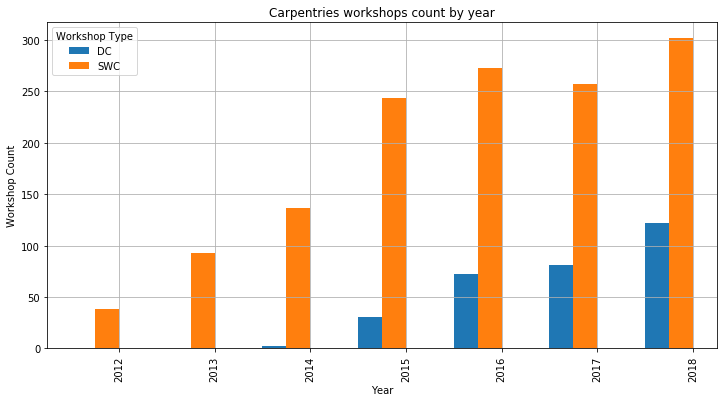

In [40]:
fig = plt.figure(figsize=(12, 6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
width = .5
title = "Carpentries workshops count by year"
workshops_by_carpentry_year_with_projections.plot(y = ["DC", "SWC"], kind='bar', ax=ax, width=width, position=1, title=title)
ax.grid(True)

ax.set_xlabel("Year")
ax.set_ylabel("Workshop Count")

plt.show()

In [198]:
##################
# Creates table of workshops by country. 2018 is actual data
##################

workshops_by_country_year = workshops_nonTTT.groupby(['country', workshops_nonTTT['start_date'].dt.year])['slug'].count().unstack()
# add_totals(workshops_by_country_year)
# table of each year and each country, 2018 is actual


# First workshop by country
* Note Pakistan held its first workshop in June 2018
* Full data in appendix

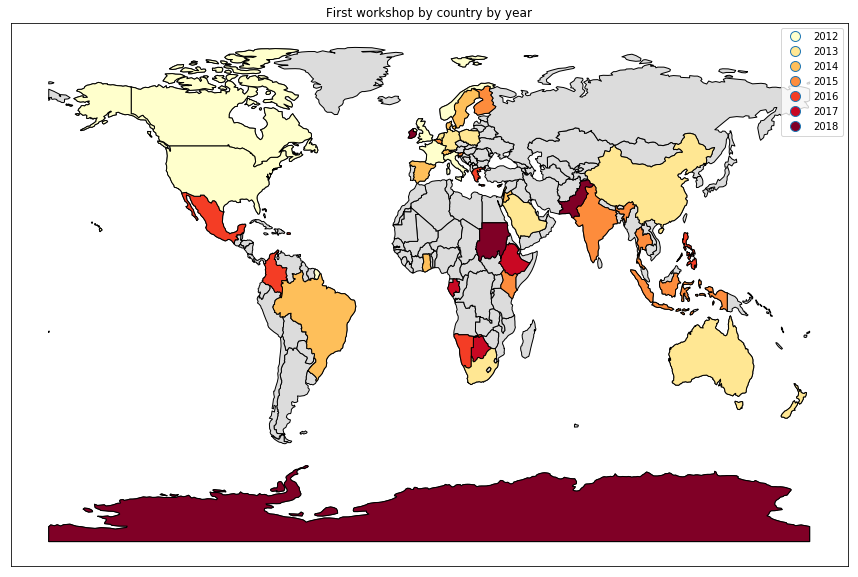

In [199]:


# When did each country have its first workshop?

w2 = workshops_by_country_year.copy()

# See https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns
# and
# https://stackoverflow.com/questions/38467749/find-first-non-zero-value-in-each-row-of-pandas-dataframe

# Fill zero values with Nan to make them non valid values
res = w2[w2 != 0.0]
first_workshop = res.apply(pd.Series.first_valid_index, axis=1)

# Create a new data frame with columns for year and country
first_workshop = pd.DataFrame({'year': first_workshop.values.astype(str), 'country': first_workshop.index.values}, index=None)

# Sort this by year
first_workshop.sort_values(by='year', inplace=True)

# Change "2018Q1" to 2018
first_workshop.replace('2018Q1', 2018, inplace=True)

# Make all values ints
first_workshop.year = first_workshop.year.astype(int)
# first_workshop

# Make country a column, not index
# first_workshop.reset_index(inplace=True)


# Rename column "country" to "name" to be able to merge with geodata
first_workshop.rename(columns={'country':'name'}, inplace=True)

# Merge first_workshop df and geodata df to a df used for map
first_wkshp_map = pd.merge(world, first_workshop, on='name', how='left')

# Create map canvas
fig, ax = plt.subplots(figsize=(15,10))


# Fill NAs with Zero so map can read
first_wkshp_map.fillna(0, inplace=True)

# Drop the zero values so they are not in the legend or color scale
first_wkshp_map = first_wkshp_map[(first_wkshp_map.year != 0)]

title = "First workshop by country by year"
ax.set_title(title)
ax.get_figure().suptitle("")

# Years as ints, not floats
first_wkshp_map['year'] = first_wkshp_map['year'] .astype(int) 

# Plot basemap all in gray
world.plot(ax=ax, color='#DCDCDC', edgecolor='black')


# Overlay plot of countries in color scale
first_wkshp_map.plot(ax=ax, column='year', categorical=True, legend=True, cmap="YlOrRd", edgecolor = 'black')

# Drop x & y axis ticks
plt.xticks([], [])
plt.yticks([], [])


plt.show()



In [200]:
#################
# Table with projections of workshops by country for 2018
##############

# Get all workshops for 2017
workshops_2017 = workshops_nonTTT[(workshops_nonTTT['start_date'].dt.year == 2017)]

# # Get all workshops for 2017 Q1 and Q2
workshops_2017Q1Q2 = workshops_nonTTT[(workshops_nonTTT['start_date'].dt.year == 2017) & (workshops_nonTTT['start_date'].dt.month <= 6)]

# # Get all workshops for 2018 Q1 and Q2
workshops_2018Q1Q2 = workshops_nonTTT[(workshops_nonTTT['start_date'].dt.year == 2018) & (workshops_nonTTT['start_date'].dt.month <= 6)]

# 2017 Q1Q2 workshops by country
workshops_by_country_year_2017Q1Q2 = workshops_2017Q1Q2.groupby(['country', workshops_nonTTT['start_date'].dt.year])['slug'].count().unstack()
workshops_by_country_year_2017Q1Q2.rename(columns={2017:'2017Q1Q2'}, inplace=True)

# 2018 Q1Q2 workshops by country
workshops_by_country_year_2018Q1Q2 = workshops_2018Q1Q2.groupby(['country', workshops_nonTTT['start_date'].dt.year])['slug'].count().unstack()
workshops_by_country_year_2018Q1Q2.rename(columns={2018:'2018Q1Q2'}, inplace=True)

# 2017 workshops by country
workshops_by_country_year_2017 = workshops_2017.groupby(['country', workshops_nonTTT['start_date'].dt.year])['slug'].count().unstack()

# Concatenated table, 2017 Q1Q2 and 2018 Q1Q2 workshops by country
workshops_by_country_year_1718Q1Q2 = pd.concat([workshops_by_country_year_2017Q1Q2, workshops_by_country_year_2018Q1Q2, workshops_by_country_year_2017], axis=1)

# # Add column to show what percent of 2017 workshops took place in 2017 Q1Q2
workshops_by_country_year_1718Q1Q2['prop2017Q1Q2'] = workshops_by_country_year_1718Q1Q2['2017Q1Q2']/workshops_by_country_year_1718Q1Q2[2017]

# # Add column to show expected 2018 workshops, if rate is same as 2017
workshops_by_country_year_1718Q1Q2['proj2018'] =  workshops_by_country_year_1718Q1Q2['2018Q1Q2']/workshops_by_country_year_1718Q1Q2['prop2017Q1Q2']

# # Give df a better name
workshops_by_country_year_with_projections = workshops_by_country_year_1718Q1Q2

# # # Relying only on 2017 projections excludes countries that held a workshop in 2018 Q1 but not 2017 Q1
# # # Adjust the 2018 projections to be the max of the 2018 projection or the 2018 Q1 actual
workshops_by_country_year_with_projections["adj_proj2018"] = workshops_by_country_year_with_projections[["proj2018", "2018Q1Q2"]].max(axis=1)


# # # Fill NA with 0 and cast floats as ints
workshops_by_country_year_with_projections = workshops_by_country_year_with_projections.fillna(0)
workshops_by_country_year_with_projections = workshops_by_country_year_with_projections.astype(int)


workshops_by_country_year_with_projections = workshops_by_country_year_with_projections.reset_index()
workshops_by_country_year_with_projections = workshops_by_country_year_with_projections.rename(columns={'index':'country'})

# # Table used to calculate 2018 projections - uncomment next line to hide/show
# workshops_by_country_year_with_projections

# workshops_by_country_year_with_projections




# Countries hosting 10 or more workshops

Note in only 2 years Ethiopia has joined the ranks


TODO: 
* Identify/discuss reasons why countries may have seen spike in 2016/17 and decline since then
* Move table to appendix
* Make numbers ints, not floats

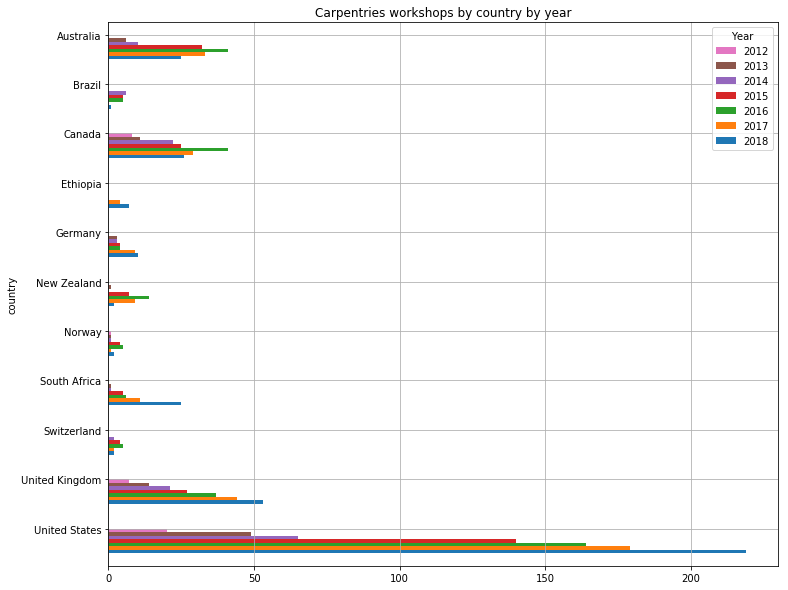

Year,2012,2013,2014,2015,2016,2017,2018
country,,,,,,,
United States,20.0,49.0,65.0,140.0,164.0,179.0,219
United Kingdom,7.0,14.0,21.0,27.0,37.0,44.0,53
Switzerland,0.0,0.0,2.0,4.0,5.0,2.0,2
South Africa,0.0,1.0,1.0,5.0,6.0,11.0,25
Norway,1.0,1.0,1.0,4.0,5.0,1.0,2
New Zealand,0.0,1.0,0.0,7.0,14.0,9.0,2
Germany,0.0,3.0,3.0,4.0,4.0,9.0,10
Ethiopia,0.0,0.0,0.0,0.0,0.0,4.0,7
Canada,8.0,11.0,22.0,25.0,41.0,29.0,26


In [201]:
# All workshops by country by year, no projections for 2018
# workshops_by_country_year


# Of those get just the ones with more than 10 workshops lifetime
workshops_by_country_year_many = workshops_by_country_year[workshops_by_country_year.sum(axis=1) >= 10]
workshops_by_country_year_many = workshops_by_country_year_many.reset_index()

# workshops_by_country_year_many = workshops_by_country_year_many.fillna(0)
# workshops_by_country_year_many = workshops_by_country_year_many.astype(int)

workshops_by_country_year_top = pd.merge(workshops_by_country_year_many, workshops_by_country_year_with_projections, on='country', how='left')




# workshops_by_country_year_top = pd.merge(workshops_by_country_year_many, workshops_by_country_year_with_projections, on='country', how='left')
workshops_by_country_year_top = workshops_by_country_year_top[['country', 2012, 2013, 2014, 2015, 2016, '2017_x', 'adj_proj2018']]
workshops_by_country_year_top = workshops_by_country_year_top.rename(columns={'2017_x':2017, 'adj_proj2018':2018})

workshops_by_country_year_top = workshops_by_country_year_top.fillna(0)
workshops_by_country_year_top[2018] = workshops_by_country_year_top[2018].astype(int)
workshops_by_country_year_top.columns.names = ['Year']

workshops_by_country_year_top.set_index('country', inplace=True)

# Draw bar chart showing most active countries and workshops by year# Draw b 

workshops_by_country_year_top = workshops_by_country_year_top[::-1]

fig = plt.figure(figsize=(12, 10)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes

title = "Carpentries workshops by country by year"
workshops_by_country_year_top.plot(y = list(workshops_by_country_year_top)[::-1], kind='barh', ax=ax, position=1, title=title)

ax.grid(True)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Year', loc='upper right')

plt.show()

workshops_by_country_year_top





# Appendix

# Table X: Workshops by Carpentry By Year
This table shows the number of Data Carpentry (DC) and Software Carpentry (SWC) workshops each year. Data for 2018 is a projection.  The proportion of workshops in the first two quarters of 2017 relative to the full year was applied to actual first two quarters data from 2018.

In [32]:
add_totals(workshops_by_carpentry_year_with_projections)

Workshop Type,DC,SWC,row total
Year,,,
2012,0,38,76
2013,0,93,186
2014,2,137,278
2015,31,243,548
2016,72,273,690
2017,81,257,676
2018,122,302,848
column total,308,1343,3302


## Table X: List of countries that held their first workshop each year

In [38]:
first_workshop.set_index('year')


,name
year,
2012,France
2012,United Kingdom
2012,United States
2012,Italy
2012,Canada
2012,Norway
2013,New Zealand
2013,Poland
2013,Saudi Arabia


## Table X: Total workshops by country by year

TODO: make numbers ints, not floats

In [55]:
workshops_by_country_year


start_date,2012,2013,2014,2015,2016,2017,2018
country,,,,,,,
Antarctica,NaN,NaN,NaN,NaN,NaN,NaN,1.0
Australia,NaN,6.0,10.0,32.0,41.0,33.0,14.0
Belgium,NaN,NaN,NaN,1.0,NaN,1.0,1.0
Botswana,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Brazil,NaN,NaN,6.0,5.0,5.0,NaN,1.0
Canada,8.0,11.0,22.0,25.0,41.0,29.0,13.0
China,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Colombia,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Cyprus,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [58]:
workshops_nonTTT.dtypes

slug             object        
start_date       datetime64[ns]
attendance       float64       
host_name        object        
country          object        
workshop_type    object        
dtype: object

In [142]:
# All workshops 2012 through 2017

workshops_by_country_year_through_2017 = workshops_nonTTT[workshops_nonTTT['start_date'].dt.year<=2017]
workshops_by_country_year_through_2017 = workshops_by_country_year_through_2017.groupby([workshops_by_country_year_through_2017['start_date'].dt.year, 'country'])['slug'].count().unstack()
# workshops_by_carpentry_year_through_2017['total'] = workshops_by_carpentry_year_through_2017.sum(axis=1)

# print("Workshops through 2017")
# display(workshops_by_country_year_through_2017)

# # # All workshops in 2017 full year - raw
workshops_by_country_year_2017 = workshops_nonTTT[workshops_nonTTT['start_date'].dt.year == 2017]


# # # All workshops in 2017 Q1 and Q2 - raw then aggregate
workshops_by_country_year_2017Q1Q2 = workshops_by_country_year_2017[workshops_by_country_year_2017['start_date'].dt.month <= 6]                                              
workshops_by_country_year_2017Q1Q2 = workshops_by_country_year_2017Q1Q2.groupby([workshops_by_country_year_2017Q1Q2['start_date'].dt.year, 'country'])['slug'].count().unstack()

# print("Workshops in 2017 Q1-Q2")
# display(workshops_by_country_year_2017Q1Q2)


# # # All workshops in 2017 full year - aggregate

workshops_by_country_year_2017 = workshops_by_country_year_2017.groupby([workshops_by_country_year_2017['start_date'].dt.year, 'country'])['slug'].count().unstack()


# print("Workshops in 2017")
# display(workshops_by_country_year_2017)

# # # All workshops in 2018 Q1-Q2
# # # Do not need to limit to month<=6 because dataset is already limited as such
workshops_by_country_year_2018Q1Q2 = workshops_nonTTT[workshops_nonTTT['start_date'].dt.year == 2018]
workshops_by_country_year_2018Q1Q2 = workshops_by_country_year_2018Q1Q2.groupby([workshops_by_country_year_2018Q1Q2['start_date'].dt.year, 'country'])['slug'].count().unstack()
# workshops_by_country_year_2018Q1Q2.fillna(0, inplace=True)

# print("Q1-Q2 2018")
# display(workshops_by_country_year_2018Q1Q2)



# # # # Proportion of 2017 workshops that took place in 2017 Q1-Q2
proportion = workshops_by_country_year_2017Q1Q2/workshops_by_country_year_2017
# proportion = proportion.rename(index={2017:2018})
# display(proportion)

# # # # # Use proportion to calculate 2018 projections
workshops_by_country_year_2018_projected = workshops_by_country_year_2018Q1Q2 / proportion
# workshops_by_country_year_2018_projected.fillna(0, inplace=True)
# workshops_by_country_year_2018_projected = workshops_by_country_year_2018_projected.astype(int)
# # DO not use total here; total will be added back to the df later
# # workshops_by_carpentry_year_2018_projected['total'] = workshops_by_carpentry_year_2018_projected.sum(axis=1)
# workshops_by_country_year_2018Q1Q2

# print("*****PROPORTIONS*****")
# display(proportion)

# print("***** 2018 Q1-Q2 *****")
# display(workshops_by_country_year_2018Q1Q2)

# # # # # Combine real data through 2017 and projected 2018 data in to one dataframe
# workshops_by_country_year_with_projections = pd.concat([workshops_by_country_year_through_2017, workshops_by_country_year_2018_projected], axis=0)
# print("****************************************************************")
# # # # # # Fill na with zeros and make floats in to ints
workshops_by_country_year_with_projections = workshops_by_country_year_with_projections.fillna(0)
# workshops_by_country_year_with_projections = workshops_by_country_year_with_projections.astype(int)



# workshops_by_country_year_with_projections.columns.names = ["Country"]
# workshops_by_country_year_with_projections.index.names = ["Year"]

# workshops_by_country_year_with_projections.T

# workshops_by_country_year_2018Q1Q2 + proportion.ix[0].reindex(workshops_by_country_year_2018Q1Q2.columns).fillna(0)
\

start_date,2012,2013,2014,2015,2016,2017,2018
country,,,,,,,
Antarctica,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Australia,NaN,NaN,NaN,NaN,NaN,51.0,NaN
Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Botswana,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brazil,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Canada,NaN,NaN,NaN,NaN,NaN,43.0,NaN
China,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Colombia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cyprus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


country,Australia,Canada,Germany,Ghana,Mexico,Netherlands,New Zealand,Norway,South Africa,Spain,Thailand,United Kingdom,United States
start_date,,,,,,,,,,,,,
2017,18,14,6,1,1,1,7,1,3,1,1,19,89


In [100]:
workshops_by_country_year_with_projections.sum(axis=0)


Country
Antarctica                           0  
Australia                            147
Belgium                              2  
Botswana                             1  
Brazil                               16 
Canada                               162
China                                1  
Colombia                             1  
Cyprus                               1  
Denmark                              6  
Ethiopia                             4  
Finland                              2  
France                               7  
Gabon                                1  
Germany                              33 
Ghana                                2  
Greece                               1  
India                                1  
Indonesia                            1  
Ireland                              0  
Italy                                4  
Jordan                               1  
Kenya                                2  
Korea, Republic of                   5  
Lebanon 